### Importando as libs e definindo as funções básicas

In [266]:
# 0.0. Importando as libs

from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 0.1. Construindo a path de input e importanto o dataframe

script_path = os.getcwd()
cutting_string = "Scripts"

partes = script_path.split(cutting_string)
path_insumos = partes[0] + "Insumos\\Semi-tratado (v2)"

df = pd.read_excel(path_insumos + "\\Semitratado.xlsx")

# O intervalo de corte de outlier é uma variável que deve ser declarada a fim de agrupar os dados
# de x em x dias para detectar outliers nesse meio. A ideia é, com isso, suavizar a curva a medida
# que aumentamos o intervalo de corte de outlier, levando em conta que quanto maior a amostra, 
# mais discrepâncias serão detectadas.
intervalo_de_corte_outliers = 15

# Já o intervalo de agrupamento diz respeito mais a visualização dos dados em gráficos de linha.
# Ou seja, se eu quero diminuir o número de dados que são mostrados, eu utilizo essa variável para
# dizer qual o intervalo que irei fazer a média e, então, exibir a média no gráfico. 
intervalo_de_agrupamento = 15

# 1.0. Construindo a função que anula outliers

def anula_outliers(series):
    # Calcular o primeiro e terceiro quartis
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    # Calcular o IQR
    IQR = Q3 - Q1
    # Definir limites para considerar um dado como outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Substituir os outliers por NaN
    series[(series < lower_bound) | (series > upper_bound)] = np.nan
    return series

# 1.1. Construindo a função que seleciona as colunas e apaga os outliers dado o intervalo

def anula_outliers_colunas_selecionadas(df, colunas, intervalo_de_dias):

    if 'Data da Coleta' not in colunas:
        # Selecionar apenas as colunas desejadas

        # Criando uma cópia da lista original para não modificar a lista original
        colunas_modificadas = colunas.copy()
        colunas_modificadas.append('Data da Coleta')
        temp_df = df[colunas_modificadas].copy()

    else:
        temp_df = df[colunas].copy()
    
    # Garantir que a coluna 'Data da Coleta' está no formato datetime e usá-la como índice
    temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')
    temp_df.set_index('Data da Coleta', inplace=True)

    # Agrupar dados por intervalo de dias e aplicar a função para substituir outliers por NaN em cada grupo
    temp_df = temp_df.resample(f'{intervalo_de_dias}D').apply(lambda x: anula_outliers(x))
    
    # Resetar o índice para voltar 'Data da Coleta' como uma coluna
    temp_df.reset_index(inplace=True)
    
    if 'Data da Coleta' not in colunas:
        # Selecionar apenas as colunas desejadas
        temp_df = temp_df[colunas].copy()
        
    else:
        pass

    return temp_df

# 1.2. Construindo a função de média os dados no intervalo

def media_intervalo(df, intervalo_de_dias):

    temp_df = df.copy()

    # Garantir que a coluna 'Data da Coleta' está no formato datetime e usá-la como índice
    df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'])
    df.set_index('Data da Coleta', inplace=True)

    # Calcular a média para o intervalo especificado
    temp_df = df.resample(f'{intervalo_de_dias}D').mean()

    # Resetar o índice para voltar 'Data da Coleta' como uma coluna
    temp_df.reset_index(inplace=True)

    return temp_df


### Gerando os gráficos de linhas

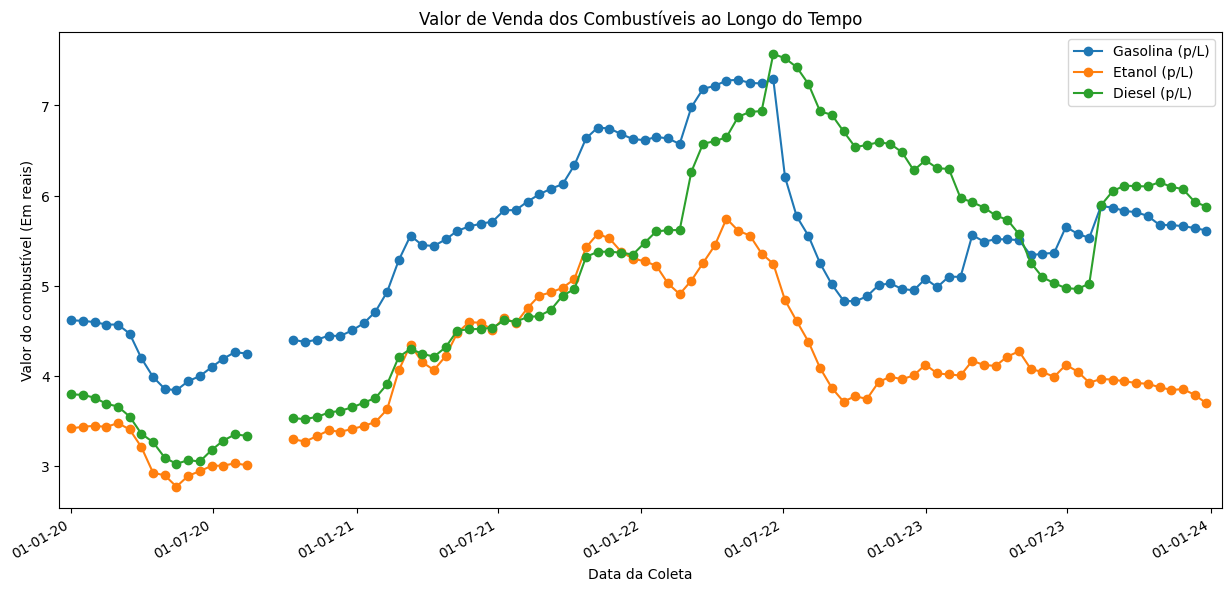

In [267]:
# 2.0. Valor de Venda dos Combustíveis ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Gasolina (p/L)'], label='Gasolina (p/L)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Etanol (p/L)'], label='Etanol (p/L)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda Diesel (p/L)'], label='Diesel (p/L)', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Valor de Venda dos Combustíveis ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor do combustível (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- Os preços dos combustíveis têm movimento semelhante ao longo do tempo, indicando uma forte correlação entre as variáveis.
- A ausência de dados no segundo semestre de 2020 foi causada, provavelmente, pela pandemia.

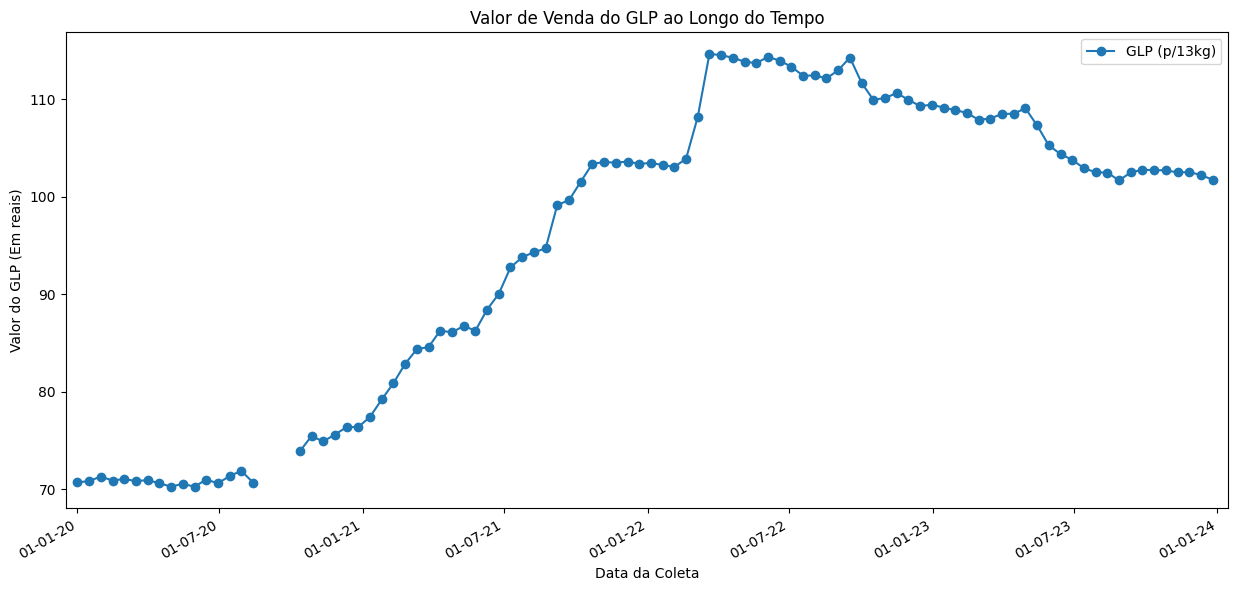

In [268]:
# 2.1. Valor de Venda do GLP ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Valor de Venda GLP (p/13kg)'], label='GLP (p/13kg)', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Valor de Venda do GLP ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor do GLP (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- É notado um alto crescimento do valor do GLP do início ao fim de 2021.
- A ausência de dados no segundo semestre de 2020 foi causada, provavelmente, pela pandemia.

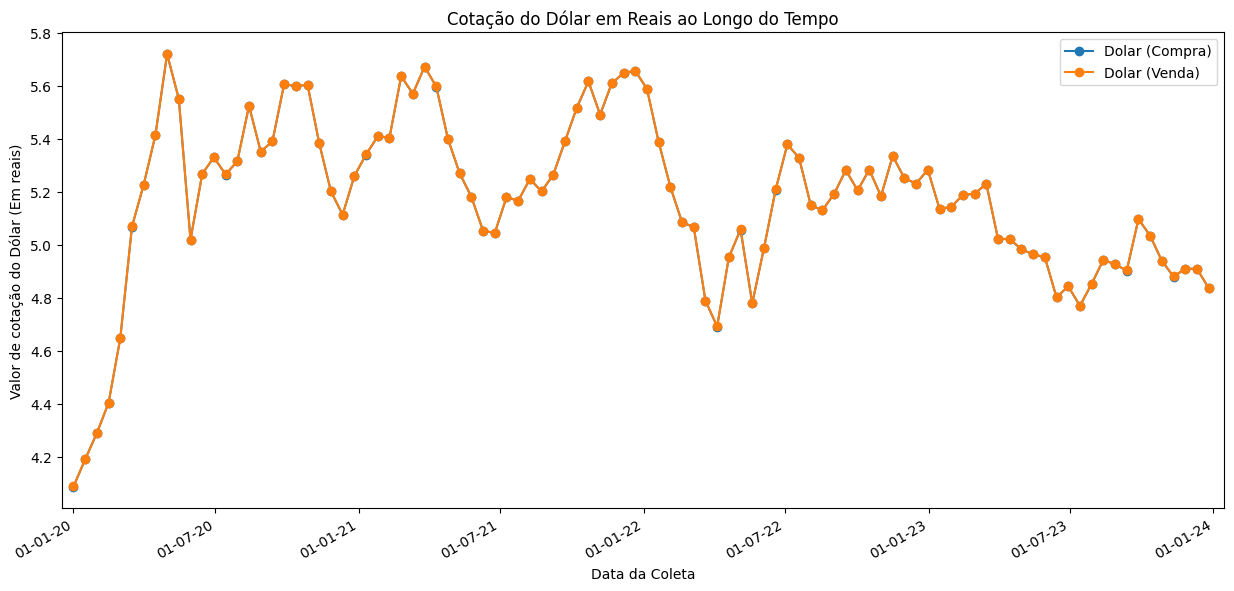

In [269]:
# 2.2. Cotação do dólar ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Cotação Dolar em Real (Compra)',
                                                   'Cotação Dolar em Real (Venda)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Cotação Dolar em Real (Compra)'], label='Dolar (Compra)', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Cotação Dolar em Real (Venda)'], label='Dolar (Venda)', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Cotação do Dólar em Reais ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor de cotação do Dólar (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- Pode ser notado um crescimento exacerbado na cotação do Dólar no primeiro semestre de 2020, causado pela pandemia. Ao passar do tempo, é notável que há fortes variações no valor da moeda, com muitos picos e vales, apesar de haver uma tendência de queda a partir do segundo semestre de 2020. 

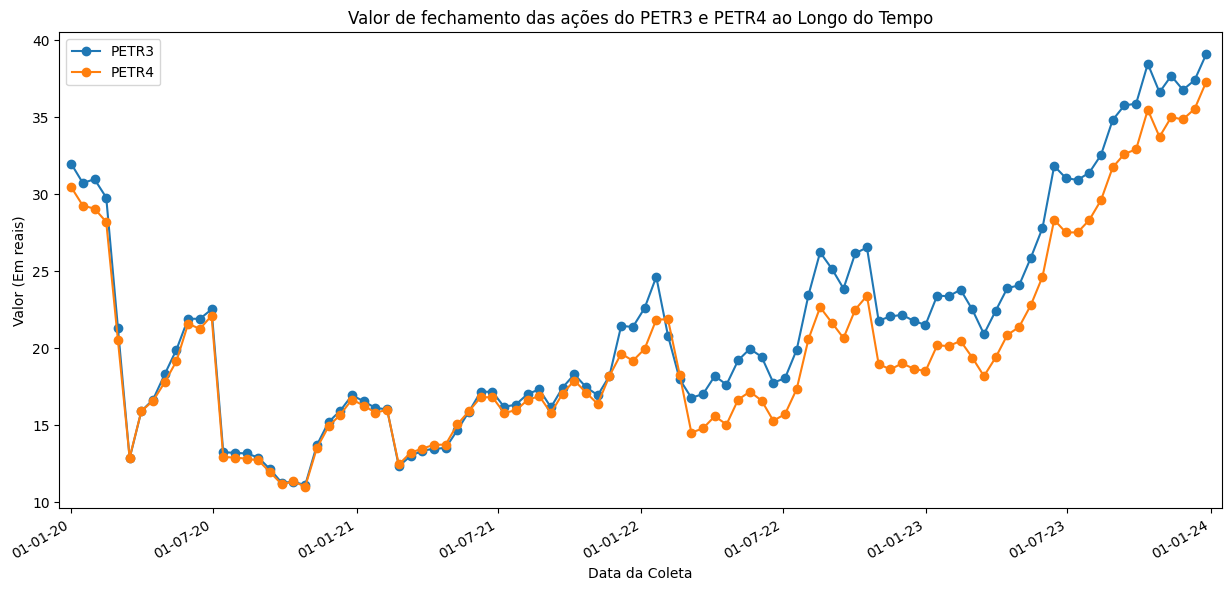

In [270]:
# 2.3. Valor de fechamento de PETR3 e PETR4 ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Fechamento PETR3 (em Reais)', 
                                                   'Fechamento PETR4 (em Reais)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Fechamento PETR3 (em Reais)'], label='PETR3', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Fechamento PETR4 (em Reais)'], label='PETR4', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Valor de fechamento das ações do PETR3 e PETR4 ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Valor (Em reais)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- No primeiro semestre de 2020, é possível observar uma queda forte no valor das ações do petróleo brasileiro, que mesmo com o seguinte crescimento, não deixou de manter baixa quando comparado aos valores anteriores. No entanto, há uma tendência de crescimento no valor das ações do petróleo brasileiro a partir disso, superando até mesmo o valor inicial no fim de 2023.

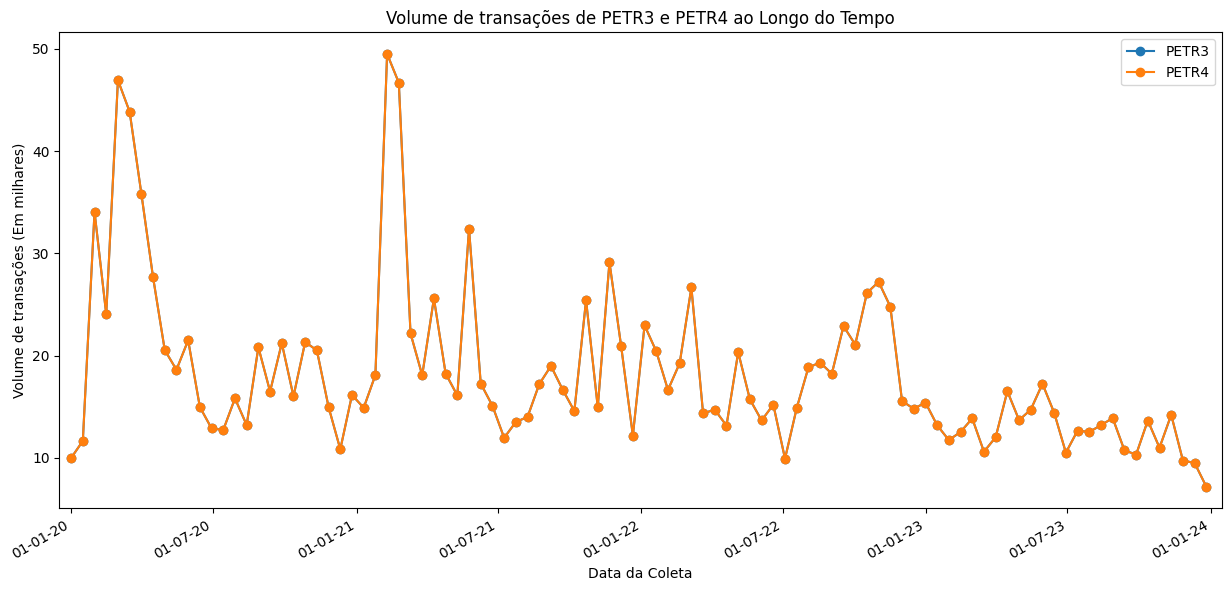

In [271]:
# 2.4. Volume de transações de PETR3 e PETR4 ao Longo do Tempo

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Volume de transações PETR3 (Em milhares)', 
                                                   'Volume de transações PETR4 (Em milhares)'], 
                                                   intervalo_de_corte_outliers)

temp_df = media_intervalo(temp_df, intervalo_de_agrupamento)

# --- #

# Convertendo a coluna 'Data da Coleta' de string para datetime
temp_df['Data da Coleta'] = pd.to_datetime(temp_df['Data da Coleta'], format='%Y%m%d')

# Criando o plot
plt.figure(figsize=(15, 7))
plt.plot(temp_df['Data da Coleta'], temp_df['Volume de transações PETR3 (Em milhares)'], label='PETR3', marker='o', linestyle='-')
plt.plot(temp_df['Data da Coleta'], temp_df['Volume de transações PETR3 (Em milhares)'], label='PETR4', marker='o', linestyle='-')

# Formatando o eixo x
ax = plt.gca()
# Estendendo os limites para antes e depois das datas desejadas
data_inicio = pd.Timestamp('2020-01-01') - pd.Timedelta(days=15)  # 15 dias antes
data_fim = pd.Timestamp('2023-12-31') + pd.Timedelta(days=15)  # 15 dias depois
ax.set_xlim([data_inicio, data_fim])

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate() # Auto formatar as datas para evitar sobreposição

# Adicionando título e labels
plt.title('Volume de transações de PETR3 e PETR4 ao Longo do Tempo')
plt.xlabel('Data da Coleta')
plt.ylabel('Volume de transações (Em milhares)')
plt.legend()

# Mostrar o gráfico
plt.show()

Insights:
- O volume de transações do petróleo brasileiro no primeiro semestre de 2020 indica venda e desvalorização da mesma no período (Levando em conta também a baixa no valor das ações no mesmo período.). No entanto, observa-se uma tendtência de queda no número de transações a partir desse período.
- São notados picos no número de transações do petróleo brasileiro, principalmente no começo do primeiro semestre, que têm um pico anormal quando comparado com as demais variações, abrindo possibilidade de investigações mais aprofundadas futuramente. 

# Gerando os gráficos de correlação

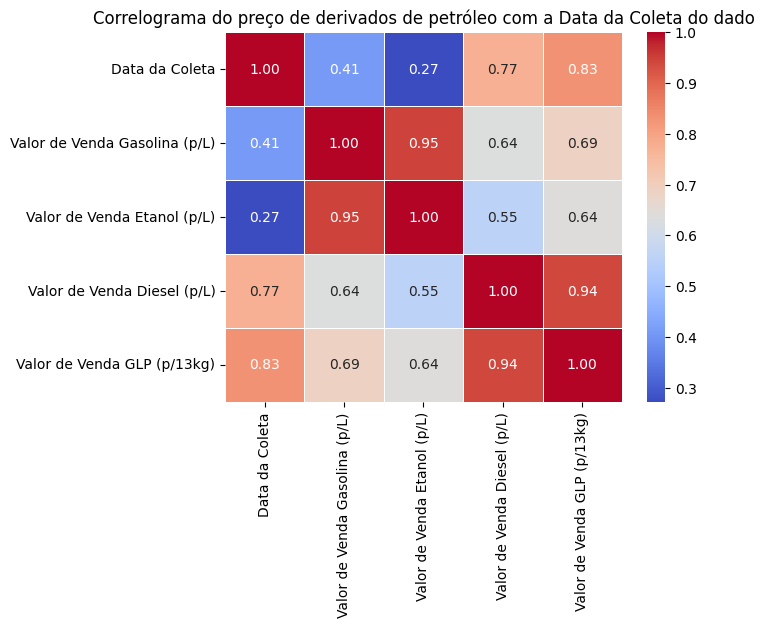

In [272]:
# 3.0. Correlação entre cada um dos combustíveis e GLP

temp_df = anula_outliers_colunas_selecionadas(df, ['Data da Coleta',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)


# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com a Data da Coleta do dado')
plt.show()

Insights:
- A forte correlação positiva entre a data de coleta e o Valor de venda do GLP indica que o preço de venda do gás de cozinha está aumentando com o passar do tempo. O mesmo processo também ocorre com os demais derivados de petróleo, mas com correlação não tão forte.
- Também é notável a forte correlação positiva entre os preços da gasolina e do etanol e entre os preços do diesel e do GLP. Abrindo possibilidade para futuras investigações.

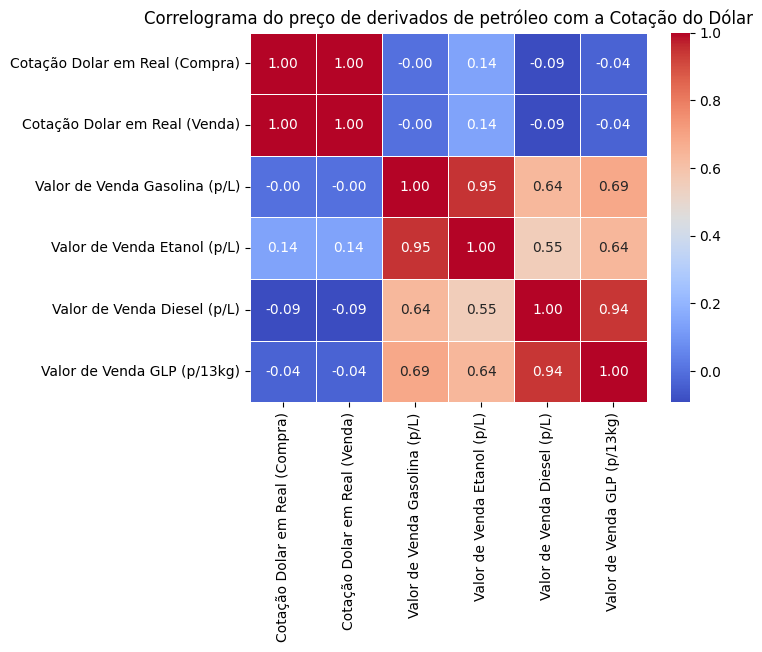

In [273]:
# 3.1. Correlação do preço de derivados de petróleo com a Cotação do Dólar

temp_df = anula_outliers_colunas_selecionadas(df, ['Cotação Dolar em Real (Compra)',
                                                   'Cotação Dolar em Real (Venda)',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)

# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com a Cotação do Dólar')
plt.show()

Insights:
- Ao contrário do que se imaginava, não há uma correlação forte, (inclusive, quase nula) entre a cotação do Dólar e o preços dos derivados de petróleo no Brasil

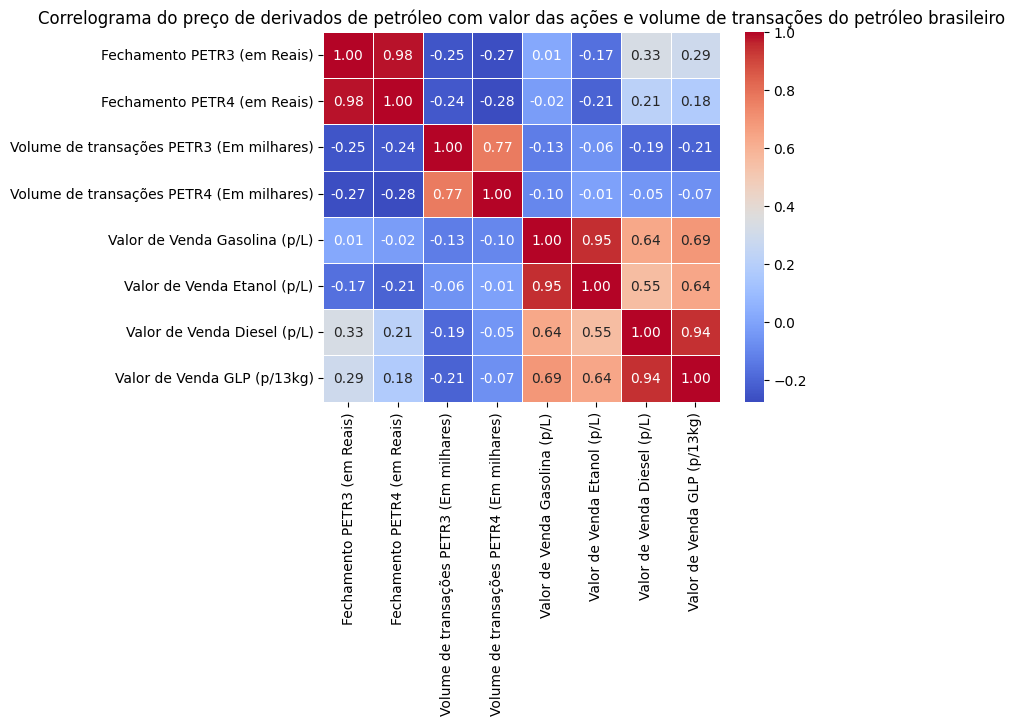

In [274]:
# 3.2. Correlação do preço de derivados de petróleo com a valor da ações do petróleo e o volume de transações das ações de petróleo

temp_df = anula_outliers_colunas_selecionadas(df, ['Fechamento PETR3 (em Reais)', 
                                                   'Fechamento PETR4 (em Reais)',
                                                   'Volume de transações PETR3 (Em milhares)', 
                                                   'Volume de transações PETR4 (Em milhares)',
                                                   'Valor de Venda Gasolina (p/L)', 
                                                   'Valor de Venda Etanol (p/L)',
                                                   'Valor de Venda Diesel (p/L)',
                                                   'Valor de Venda GLP (p/13kg)'], 
                                                   intervalo_de_corte_outliers)

# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com valor das ações e volume de transações do petróleo brasileiro')
plt.show()

Insights:
- Assim como anteriormente notado, ao contrário do que se imaginava, não há correlação forte (ao menos, não notada com os atuais dados), entre o valor das ações do petróleo brasileiro, o volume de transações do petróleo brasileiro e o valor dos derivados de petróleo. Evidenciando uma correlação quase de nula.

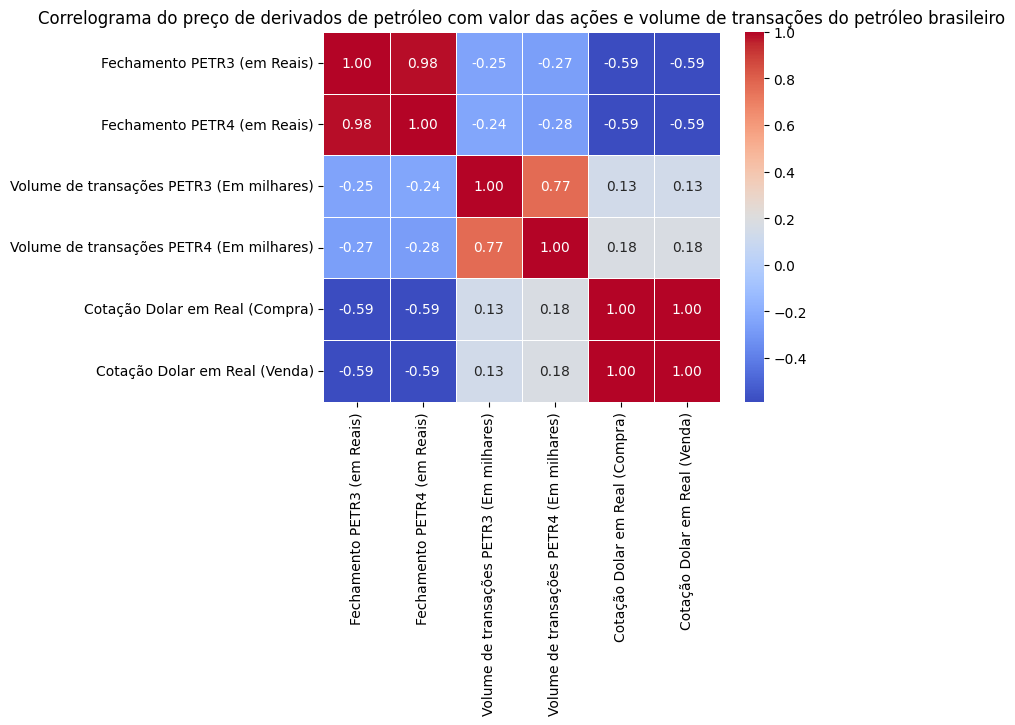

In [275]:
# 3.2. Correlação do preço de derivados de petróleo com a valor da ações do petróleo e o volume de transações das ações de petróleo

temp_df = anula_outliers_colunas_selecionadas(df, ['Fechamento PETR3 (em Reais)', 
                                                   'Fechamento PETR4 (em Reais)',
                                                   'Volume de transações PETR3 (Em milhares)', 
                                                   'Volume de transações PETR4 (Em milhares)',
                                                   'Cotação Dolar em Real (Compra)',
                                                   'Cotação Dolar em Real (Venda)'], 
                                                   intervalo_de_corte_outliers)

# --- #

# Calculando a matriz de correlação
correlation_matrix = temp_df.corr()

# Criando o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlograma do preço de derivados de petróleo com valor das ações e volume de transações do petróleo brasileiro')
plt.show()